In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})
import trimesh as tr
import pyrender as pr

# load data

intrinsics
[[    511.00       0.00     320.00]
 [      0.00     511.00     256.00]
 [      0.00       0.00       1.00]]
pinhole projection matrix
[[    -75.61     -80.22      43.70     412.71]
 [      1.66      21.25     110.42     235.58]
 [      0.06      -0.14       0.11       1.00]]



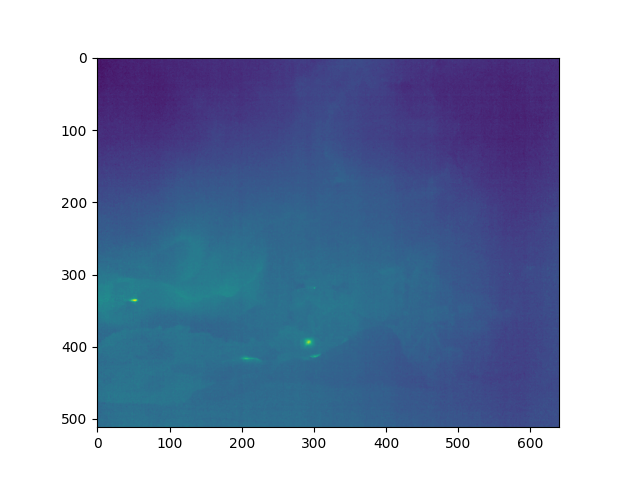

In [2]:
from src.pyushichka import loadCalibration, loadImage
ushichka_dir = "/home/julian/data/ushichka/2018-08-17/"
cam = 1 # 2nd camera
imK, imP = loadCalibration(cam, ushichka_dir)
imIm, _path_im = loadImage(cam, 0, ushichka_dir)

print(f"intrinsics\n{imK}\npinhole projection matrix\n{imP}\n")
plt.figure()
plt.imshow(imIm)
plt.show()

from src.dmcpworkflow.capture_depth import generate_depth_map
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
ovMesh = pr.Mesh.from_trimesh(tr.load_mesh(mesh_path))
pvMesh = pv.read(mesh_path)

# DMCP Workflow

## Generate Depth Map

In [3]:
print("generating depth map")
view_width = 1920
view_height = 1080

view_K = imK.copy()
view_K[0,-1] = view_width /2
view_K[1,-1] = view_width / 2

dmimIm, dmIm, dmK, dmP = generate_depth_map(ovMesh,view_K,znear=0.00001,zfar=100,return_img=True)

generating depth map
[[      0.67       0.46      -0.58      -0.46]
 [      0.74      -0.40       0.54       0.54]
 [      0.02      -0.80      -0.61      -0.32]]
[[      0.67      -0.46       0.58]
 [      0.74       0.40      -0.54]
 [      0.02       0.80       0.61]]
[[     -0.46]
 [      0.54]
 [     -0.32]]


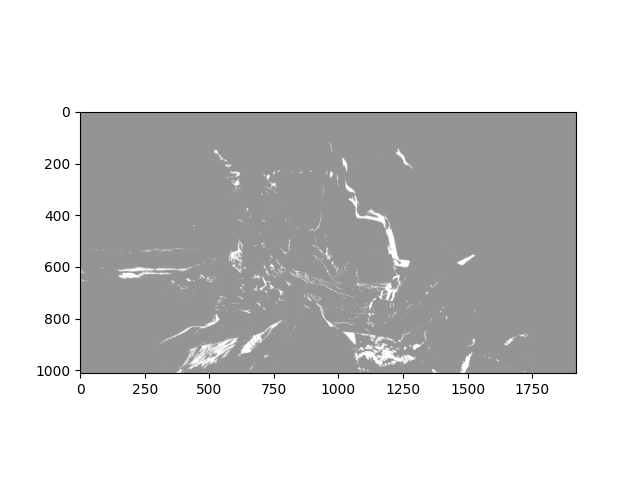

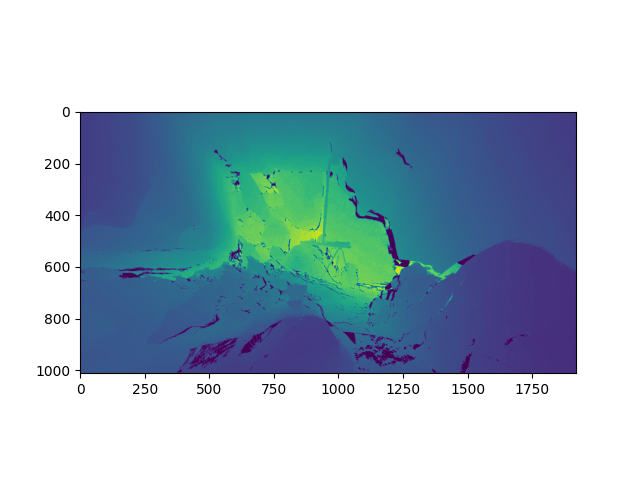

In [4]:
plt.figure()
plt.imshow(dmimIm)
plt.show()

plt.figure()
plt.imshow(dmIm)
plt.show()

## Annotate Points

In [5]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("QT5Agg")
cps = annotate(imIm, dmIm)
%matplotlib inline

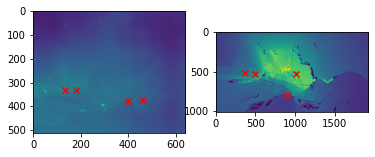

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r",marker="x")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r",marker="x")
plt.show()

## project to world

In [7]:
from src.pycv.dmcp import dm_to_world

pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
pts_world

array([[     -5.48,       5.81,       0.01],
       [     -1.55,       1.33,      -0.81],
       [     -5.73,       1.20,      -0.16],
       [     -5.22,       0.60,      -0.17]], dtype=float32)

In [8]:
# visualize cps in world coordinates

pvPts = pv.PolyData(pts_world)

pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)

pl.show()

## dmcp step

In [9]:
from src.pycv.dmcp import dmcp

trans = dmcp(imK, imP, cps[:,:2], pts_world)
print(f"transformation\n{trans}")

estimated pose
[[      0.52      -0.26      -0.82       0.65]
 [      0.85       0.23       0.47      -0.45]
 [      0.07      -0.94       0.34      -1.16]]
transformation
[[     -0.73       0.53      -0.42      17.89]
 [     -0.68      -0.56       0.48      -8.58]
 [      0.02       0.64       0.77      -6.07]
 [      0.00       0.00       0.00       1.00]]


In [10]:
print("estiated position")
P_est = imP @ la.inv(trans)
pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]

position_est = pose_est[:3].flatten()
print(position_est)

estiated position
[     22.01     -11.84      -5.62]


ESTIMATED POSE SEEMS TO BE CORRECT BUT TRANSFORMATIOON FAILES

==> Scaling?!?!

In [13]:
sv_pos_est = pv.Sphere(radius=0.5, center=(0.65,-0.45,-1.16)) # manually inserted estimated position of PnP as transformation is wrong!
pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)
pl.add_mesh(sv_pos_est, color="yellowgreen")

pl.show()